In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
from numba import jit

matplotlib.rc("figure", figsize=(16,6))
matplotlib.rc("lines", linewidth=2)
matplotlib.rc("font", serif='Computer Modern Roman')

## Wind 

Data is from [NREL wind integration dataset](http://www.nrel.gov/electricity/transmission/wind_toolkit.html), 
site 20182.

In [2]:
def read_wind_csv(filename):
    return pd.read_csv(filename, skiprows=3, parse_dates=[[0,1,2,3,4]],
        date_parser=lambda *cols: datetime.datetime(*map(int, cols)), index_col=0)

wind = pd.concat([read_wind_csv("nrel_wind/20182-2010.csv"),
                  read_wind_csv("nrel_wind/20182-2011.csv"),
                  read_wind_csv("nrel_wind/20182-2012.csv")])
wind.index.name = ''
p_wind = wind["power (MW)"]


# to change sampling change this
p_wind = p_wind.resample('15min').asfreq()
one_day = int(24*3600 / (p_wind.index[1] - p_wind.index[0]).seconds)


train = p_wind[p_wind.index.year <= 2011]
test = p_wind[p_wind.index.year > 2011]

MIN = 0.
MAX = 16.

(<matplotlib.axes._subplots.AxesSubplot at 0x10b6d4e48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b6d4e48>)

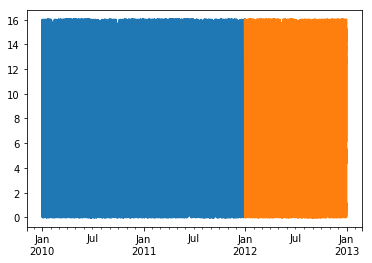

In [3]:
train.plot(), test.plot()

## Seasonal baseline

In [4]:
PERIODS = []
for harmonic in [1,2,3,4]:
    for period in [24*3600., 8766*3600]:
        PERIODS.append(period/harmonic)

def featurize_for_baseline(data, periods):
    seconds = data.index.astype(np.int64)/1E9
    X = np.zeros((len(seconds), 1+2*len(periods)))
    for i, period in enumerate(periods):  # in seconds
        for j, trig in enumerate([np.sin, np.cos]):
            #print(2 * np.pi * seconds / period)
            X[:, 2*i+j] = trig(2 * np.pi * seconds / period)
    X[:,-1] = np.ones(len(seconds))
    y = data.values
    #print(seconds)
    return X, y
    

def fit_seasonal_baseline(X, y):
    return np.linalg.solve(X.T @ X, X.T @ y)

def predict_with_baseline(X, parameters):
    return X @ parameters

Baseline train RMSE 5.513361340498253
Baseline test RMSE 5.656712957910544


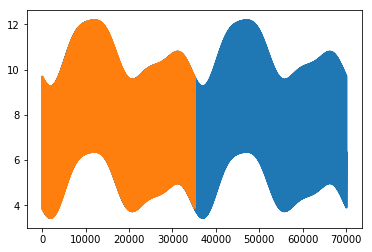

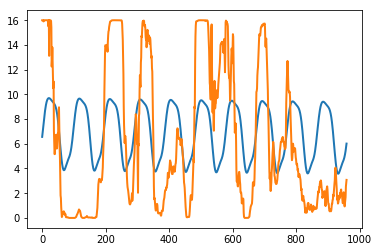

In [5]:
Xtr, ytr = featurize_for_baseline(train, PERIODS)
Xte, yte = featurize_for_baseline(test, PERIODS)

baseline_params = fit_seasonal_baseline(Xtr, ytr)

train_baseline = predict_with_baseline(Xtr, baseline_params)
test_baseline = predict_with_baseline(Xte, baseline_params)


plt.plot(train_baseline)
plt.plot(test_baseline)

plt.figure()
plt.plot(test_baseline[:one_day*10])
plt.plot(test.values[:one_day*10])

def RMSE(array):
    return np.sqrt(np.mean(array**2))

print('Baseline train RMSE', RMSE(train.values - train_baseline))
print('Baseline test RMSE', RMSE(test.values - test_baseline))

In [6]:
train_baseline_series = pd.Series(index=train.index, data=train_baseline)
test_baseline_series = pd.Series(index=test.index, data=test_baseline)

## Autoregressive residual

In [7]:
train_residual = train - train_baseline
test_residual = test - test_baseline

M, L = one_day, one_day # one day

In [8]:
@jit
def featurize_residual(obs, M, L):
    X = np.zeros((len(obs) - M - L+1, M))
    for i in range(M):
        X[:,i] = obs[M-i-1:-L-i]
        
    y = np.zeros((len(obs) - M - L+1, L))
    
    for i in range(L):
        y[:,i] = obs[M+i:len(obs)+1-L+i]
        
    return X, y

def fit_residual(X, y):
    M, L = X.shape[1], y.shape[1]
    pinv = np.linalg.inv(X.T @ X) @ X.T
    params = np.zeros((M, L))
    params = pinv @ y
    return params

In [9]:
# import cvxpy as cvx

# cvxpy_params = cvx.Variable((M,L))

# #cvx.Problem(cvx.Minimize(cvx.sum_squares(Xtr[:200] * cvxpy_params - ytr[:200])), []).solve()

# # cvx.Problem(cvx.Minimize())

# # Xtr.shape, ytr.shape

In [10]:
Xtr , ytr = featurize_residual(train_residual, M, L)
Xte , yte = featurize_residual(test_residual, M, L)

residuals_params = fit_residual(Xtr, ytr)

train_predicted_residuals = Xtr @ residuals_params
test_predicted_residuals = Xte @ residuals_params

In [11]:
Xtr.shape

(69889, 96)

In [12]:
train_predicted_residuals.shape

(69889, 96)

In [13]:
# ## Hankel projection

# hankel_params = np.array(residuals_params)

# for k in range(hankel_params.shape[0]):
#     #print([hankel_params[i,k-i] for i in range(k+1)])
#     anti_diag_mean = np.mean([hankel_params[i,k-i] for i in range(k+1)])
#     for i in range(k+1):
#         hankel_params[i,k-i] = anti_diag_mean
        
# #plt.imshow(hankel_params[:])

# def lag_RMSE(y, hat_y):
#     return np.sqrt(np.sum((y - hat_y)**2, 0)/len(y))

# plt.plot(lag_RMSE(ytr, Xtr @ hankel_params), label='train')
# plt.plot(lag_RMSE(yte, Xte @ hankel_params), label='test')

# plt.plot()
# plt.legend()

In [14]:
error = (ytr - train_predicted_residuals)
Sigma_epsilon = np.cov(error.T)

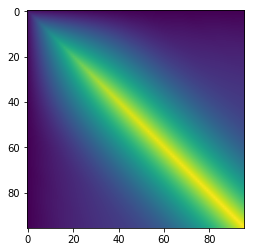

In [15]:
plt.imshow(Sigma_epsilon, interpolation='bilinear')

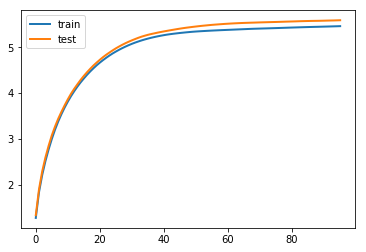

In [16]:
def lag_RMSE(y, hat_y):
    return np.sqrt(np.sum((y - hat_y)**2, 0)/len(y))

plt.plot(lag_RMSE(ytr, train_predicted_residuals), label='train')
plt.plot(lag_RMSE(yte, test_predicted_residuals), label='test')

plt.plot()
plt.legend()

(-1, 96)

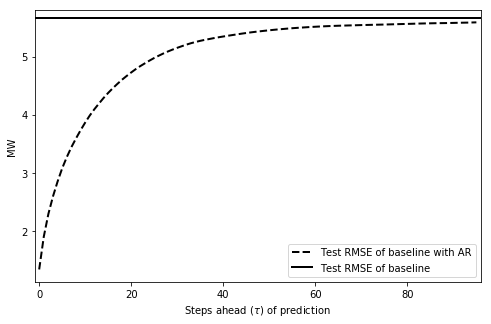

In [17]:
# Test RMSE

plt.figure(figsize=(8,5))
plt.plot(lag_RMSE(yte, test_predicted_residuals), 'k--')
plt.axhline(RMSE(test.values - test_baseline), color='k')
plt.legend(['Test RMSE of baseline with AR', 'Test RMSE of baseline'], loc='lower right')
plt.xlabel('Steps ahead ($\\tau$) of prediction')
plt.ylabel('MW')

plt.xlim([-1,L])

### Main plot

In [18]:
test_day = datetime.datetime(2012, 6, 1)
past = test[test.index < test_day][-M:]
past_baseline = test_baseline[test.index < test_day][-M:]


future = test[test.index >= test_day][:L]
future_baseline = test_baseline[test.index >= test_day][:L]

past_res = past - past_baseline

future_res_prediction = past_res.values@residuals_params


future_res = future - future_baseline



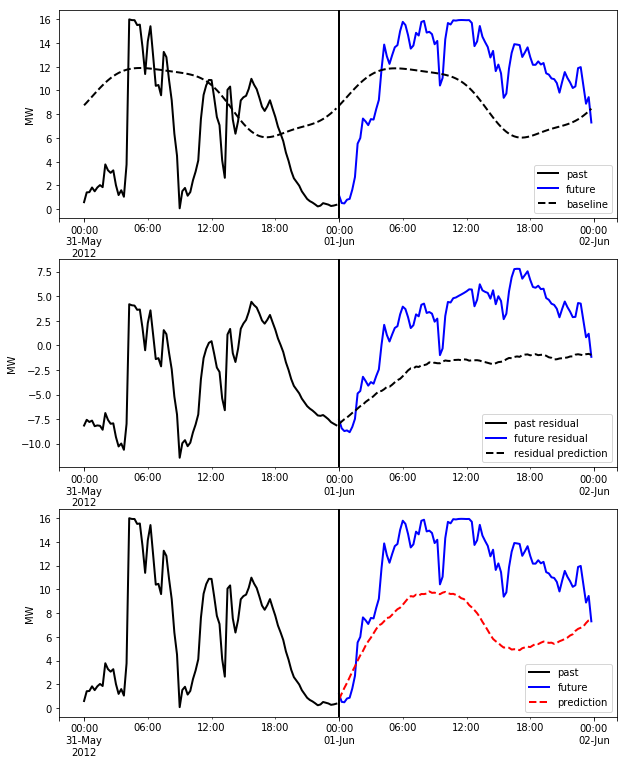

In [19]:
f, axs = plt.subplots(3,1,figsize=(10,13))


past.plot(ax=axs[0], style='k')
future.plot(ax=axs[0], style='b')
pd.Series(future_baseline, future.index).plot(ax=axs[0],style='k--')
axs[0].axvline(test_day, color='k')
pd.Series(past_baseline, past.index).plot(ax=axs[0], style='k--')

axs[0].legend(labels=['past', 'future', 'baseline'])
axs[0].set_ylabel('MW')

past_res.plot(ax=axs[1], style='k')
future_res.plot(ax=axs[1], style='b')

pd.Series(future_res_prediction, future.index).plot(ax=axs[1], style='k--')


axs[1].axvline(test_day, color='k')
axs[1].set_ylabel('MW')



axs[1].legend(labels=['past residual', 'future residual', 'residual prediction'])


past.plot(ax=axs[2], style='k')
future.plot(ax=axs[2], style='b')


pd.Series(future_baseline + future_res_prediction, future.index).plot(ax=axs[2], style='r--')

axs[2].set_ylabel('MW')


axs[2].axvline(test_day, color='k')
axs[2].legend(labels=['past', 'future', 'prediction'])


plt.savefig('../fig/appendix_wind_example.pdf')


## "Spaghetti" plot

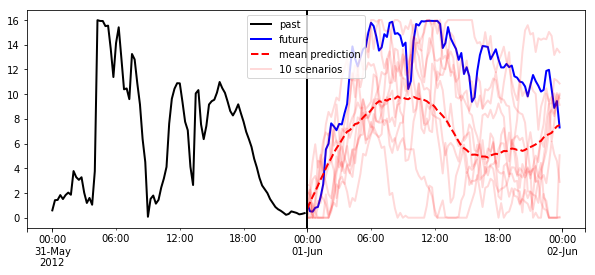

In [20]:
K = 10
scenarios = np.random.multivariate_normal(np.zeros(L), Sigma_epsilon, K)

plt.figure(figsize=(10,4))
past.plot( style='k')
future.plot( style='b')
    
pd.Series(future_baseline + future_res_prediction, future.index).plot( style='r--')


for scenario in scenarios:
    pred = pd.Series(future_baseline + future_res_prediction + scenario, future.index)
    pred = np.maximum(MIN, pred)
    pred = np.minimum(MAX, pred)
    pred.plot( style='r', alpha=.15)


plt.legend(['past', 'future', 'mean prediction', '%d scenarios' %K], loc='upper center')

plt.axvline(test_day, color='k')



plt.savefig('../fig/wind_spaghetti.pdf')

## Save everything 

In [21]:
all_baseline = pd.concat([train_baseline_series, test_baseline_series])
all_baseline.to_pickle('wind_baseline.pickle')
pd.to_pickle(residuals_params, 'residual_params.pickle')
pd.to_pickle(Sigma_epsilon, 'sigma_epsilon.pickle')
pd.to_pickle(train, 'wind_power_train.pickle')
pd.to_pickle(test, 'wind_power_test.pickle')